In [1]:
import importlib.util
import os
from copy import copy
from io import StringIO
from logging import (
    INFO,
    NOTSET,
    FileHandler,
    Formatter,
    Logger,
    StreamHandler,
    captureWarnings,
    getLogger,
)
from pathlib import Path
from shutil import rmtree

import matplotlib.pyplot as plt
import numpy as np
from ase.build.rotate import minimize_rotation_and_translation
from ase.io import read
from ase.io.trajectory import Trajectory
from ase.mep import NEB
from ase.optimize import FIRE, LBFGS
from ase.vibrations import Vibrations
from ase.visualize import view
from fairchem.core import FAIRChemCalculator
from fairchem.core.units.mlip_unit import load_predict_unit
from rdkit import Chem
from rdkit.Chem.rdDistGeom import EmbedMolecule
from rdkit.Chem.rdForceFieldHelpers import MMFFOptimizeMolecule
from sella import Sella

/home/yu9824/opt/miniforge3/envs/fairchem312/lib/python3.12/site-packages/torchtnt/utils/version.py:12: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  import pkg_resources


In [2]:
jobname = "mda-neb"

SEED = 334

In [3]:
if "__file__" in locals():
    DIRPATH_ROOT = Path(__file__).parent
else:
    DIRPATH_ROOT = Path(os.getcwd())

DIRPATH_TRAJ = DIRPATH_ROOT / "traj" / jobname
rmtree(DIRPATH_TRAJ, ignore_errors=True)
DIRPATH_TRAJ.mkdir(parents=True)

DIRPATH_LOG = DIRPATH_ROOT / "log" / jobname
rmtree(DIRPATH_LOG, ignore_errors=True)
DIRPATH_LOG.mkdir(parents=True)


In [4]:
def configure_logger() -> Logger:
    logger = getLogger("sella-tutorial")
    logger.propagate = False

    formatter = Formatter("%(asctime)s [%(levelname)s] %(message)s")

    file_handler = FileHandler(
        DIRPATH_LOG / "sella-tutorial.log",
        mode="w",  # 上書き
    )
    file_handler.setFormatter(formatter)
    file_handler.setLevel(NOTSET)

    if importlib.util.find_spec("colorlog"):
        from colorlog import ColoredFormatter

        colored_formatter = ColoredFormatter(
            "%(asctime)s [%(log_color)s%(levelname)s%(reset)s] %(message)s"
        )
    else:
        colored_formatter = formatter
    stream_handler = StreamHandler()
    stream_handler.setFormatter(colored_formatter)
    stream_handler.setLevel(NOTSET)

    captureWarnings(True)
    _logger_warnings = getLogger("py.warnings")
    _logger_warnings.handlers.clear()
    _logger_warnings.addHandler(file_handler)
    _logger_warnings.addHandler(stream_handler)
    _logger_warnings.propagate = False

    logger.handlers.clear()
    logger.addHandler(file_handler)
    logger.addHandler(stream_handler)
    logger.setLevel(INFO)

    return logger


logger = configure_logger()

In [5]:
predictor = load_predict_unit(
    Path(os.environ["HOME"]) / "uma/checkpoints/uma-s-1p1.pt", device="cuda"
)
calc = FAIRChemCalculator(predictor, task_name="omol", seed=SEED)

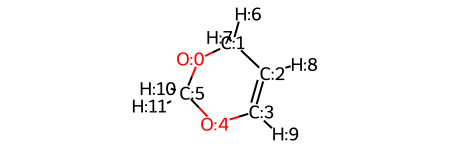

In [6]:
smiles_dummy = "O1CC=COC1"

mol_dummy = Chem.MolFromSmiles(smiles_dummy)
mol_dummy = Chem.AddHs(mol_dummy)
EmbedMolecule(mol_dummy, randomSeed=SEED)
for atom in mol_dummy.GetAtoms():
    atom.SetProp("atomLabel", f"{atom.GetSymbol()}:{atom.GetIdx()}")

mol_dummy

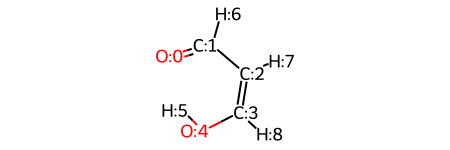

In [7]:
mol_mda_initial = Chem.RWMol(mol_dummy)
mol_mda_initial.RemoveBond(0, 5)
mol_mda_initial.RemoveAtom(11)
mol_mda_initial.RemoveAtom(10)
mol_mda_initial.RemoveAtom(7)
mol_mda_initial.GetBondBetweenAtoms(0, 1).SetBondType(Chem.BondType.DOUBLE)
mol_mda_initial.ReplaceAtom(5, Chem.Atom(1))
mol_mda_initial = mol_mda_initial.GetMol()

Chem.SanitizeMol(mol_mda_initial)
MMFFOptimizeMolecule(mol_mda_initial)

for atom in mol_mda_initial.GetAtoms():
    atom.SetProp("atomLabel", f"{atom.GetSymbol()}:{atom.GetIdx()}")

mol_mda_initial

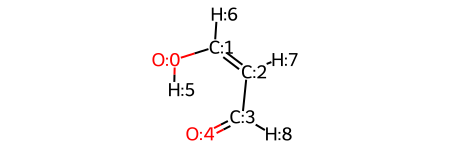

In [8]:
mol_mda_final = Chem.RWMol(mol_mda_initial)
mol_mda_final.AddBond(0, 5, Chem.BondType.SINGLE)
mol_mda_final.GetBondBetweenAtoms(0, 1).SetBondType(Chem.BondType.SINGLE)
mol_mda_final.GetBondBetweenAtoms(1, 2).SetBondType(Chem.BondType.DOUBLE)
mol_mda_final.GetBondBetweenAtoms(2, 3).SetBondType(Chem.BondType.SINGLE)
mol_mda_final.GetBondBetweenAtoms(3, 4).SetBondType(Chem.BondType.DOUBLE)
mol_mda_final.RemoveBond(4, 5)
mol_mda_final = mol_mda_final.GetMol()
Chem.SanitizeMol(mol_mda_final)
MMFFOptimizeMolecule(mol_mda_final)
mol_mda_final

In [9]:
initial = read(StringIO(Chem.MolToXYZBlock(mol_mda_initial)), format="xyz")

initial.calc = copy(calc)
initial.info["charge"] = 0
initial.info["spin"] = 1
opt_init = LBFGS(
    initial,
    logfile=str(DIRPATH_LOG / "initial.log"),
    trajectory=str(DIRPATH_TRAJ / "initial.traj"),
)
converged_init = opt_init.run(fmax=0.01)
logger.info(f"Converge initial structure: {converged_init}")

2025-08-21 16:26:03,022 [INFO] Converge initial structure: True


In [10]:
final = read(StringIO(Chem.MolToXYZBlock(mol_mda_final)), format="xyz")

final.calc = copy(calc)
final.info["charge"] = 0
final.info["spin"] = 1
opt_final = LBFGS(
    final,
    logfile=str(DIRPATH_LOG / "final.log"),
    trajectory=str(DIRPATH_TRAJ / "final.traj"),
)
converged_final = opt_final.run(fmax=0.01)
logger.info(f"Converge final structure: {converged_final}")

2025-08-21 16:26:04,863 [INFO] Converge final structure: True


In [11]:
# 座標の違いを最小にする
minimize_rotation_and_translation(initial, final)

view((initial, final), viewer="ngl")

In [12]:
# --- 2) NEB 準備
n_images = 5  # 中間像の数（増やすと経路がなめらか）
images = [initial]
images += [initial.copy() for _ in range(n_images)]
images += [final]

neb = NEB(images, k=0.1, climb=True)
neb.interpolate(method="idpp")

# 計算器
for im in images:
    im.info["charge"] = 0
    im.info["spin"] = 1
    im.calc = copy(calc)


In [13]:
# --- 3) NEB 最適化
opt_neb = FIRE(
    neb,
    logfile=str(DIRPATH_LOG / "neb.log"),
    trajectory=str(DIRPATH_TRAJ / "neb.traj"),
)
converged_neb = opt_neb.run(fmax=0.05, steps=1000)
logger.info(f"NEB converged: {converged_neb}")

2025-08-21 16:26:18,147 [INFO] NEB converged: True


In [14]:
# --- 4) 最高エネルギー像をTS初期候補として抽出
energies = np.array([a.get_potential_energy() for a in images])
energies -= energies.min()
ts_idx = int(np.argmax(energies))
ts_guess = images[ts_idx]

logger.info(
    f"NEB images: {len(images)}, TS guess index: {ts_idx}, E[max]-E[0] = {energies[ts_idx]:.3f} eV"
)

2025-08-21 16:26:18,330 [INFO] NEB images: 7, TS guess index: 3, E[max]-E[0] = 0.152 eV


In [15]:
view(images, viewer="ngl")

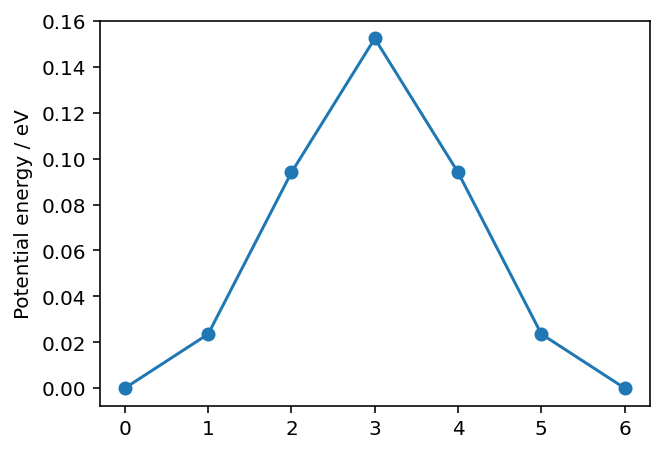

In [16]:
fig, ax = plt.subplots(dpi=144, figsize=(4.8, 3.2))
ax.plot(energies, marker="o")
ax.ticklabel_format(style="plain", useOffset=False)
ax.set_ylabel("Potential energy / eV")
fig.tight_layout()

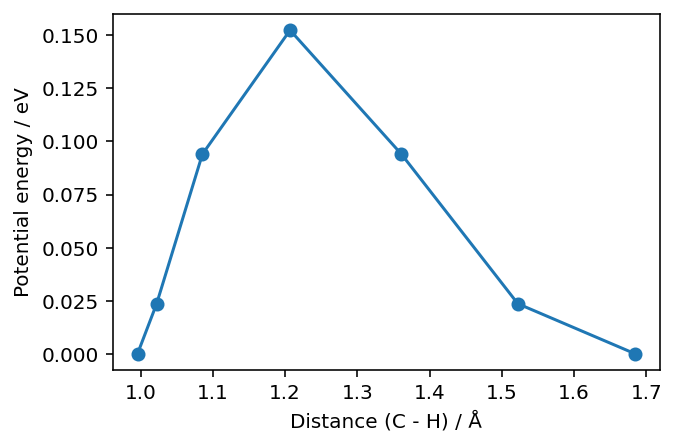

In [17]:
distance_o_and_h = np.asarray(
    [
        np.sqrt(
            (np.diff(images[frame].get_positions()[[0, 5]], axis=0) ** 2).sum()
        )
        for frame in range(len(images))
    ]
)
fig, ax = plt.subplots(dpi=144, figsize=(4.8, 3.2))
ax.plot(distance_o_and_h, energies, marker="o")
ax.ticklabel_format(style="plain", useOffset=False)
ax.set_xlabel("Distance (C - H) / Å")
ax.set_ylabel("Potential energy / eV")
fig.tight_layout()

In [18]:
# --- 5) Sella で遷移状態探索（opt='ts'）
ts_structure = ts_guess.copy()

ts_structure.calc = copy(calc)
ts_structure.info["charge"] = 0
ts_structure.info["spin"] = 1
ts_structure.set_constraint()
opt_ts = Sella(
    ts_structure,
    trajectory=str(DIRPATH_TRAJ / "ts.traj"),
    logfile=str(DIRPATH_LOG / "ts.log"),
    order=1,  # ← index-1 saddle を探す
    eta=1e-4,  # 初期ステップサイズ。大きくすると高速に移動、小さくすると安定だが遅い
    gamma=0.01,  # 反復パラメータ（Sella 固有）。勾配の反映具合を調整
    internal=True,  # 内部座標系で最適化するか。False で Cartesian 最適化
    diag_every_n=1,
)
converged_ts = opt_ts.run(fmax=1e-4)
logger.info("Sella TS search finished. See ts.traj / ts.log")
logger.info(f"Converge TS: {converged_ts}")


2025-08-21 16:26:25,732 [INFO] Sella TS search finished. See ts.traj / ts.log
2025-08-21 16:26:25,733 [INFO] Converge TS: True


In [19]:
view(ts_structure, viewer="x3d")

In [20]:
# --- 6) 振動数計算
dirpath_vib_cache = DIRPATH_TRAJ / "cache"

# 遷移状態の構造を読み込み
# ts_structure = read("ts.traj", index=-1)  # 最後の構造を取得
ts_structure.calc = copy(calc)
ts_structure.info["charge"] = 0
ts_structure.info["spin"] = 1

# 振動数計算の設定
vib = Vibrations(
    ts_structure, delta=0.01, name=str(dirpath_vib_cache), nfree=2
)  # delta: 有限差分のステップサイズ（Å）

vib.clean()
# 振動数計算を実行
vib.run()

frequencies = vib.get_frequencies()
flag_imag_freq = ~np.isclose(frequencies.imag, 0.0)
n_imag_freqs = np.sum(flag_imag_freq).item()
# 結果の表示
logger.info("=== 振動数計算結果 ===")
logger.info(f"虚振動の数: {n_imag_freqs} / {flag_imag_freq.shape[0]}")

# 虚振動数の詳細表示
str_imag_freqs = "虚振動数 (cm^-1):"
if n_imag_freqs:
    for idx, freq in enumerate(frequencies):
        if flag_imag_freq[idx]:
            str_imag_freqs += f"\n  {idx}: {freq:8.2f}"
            # 虚振動のモードを可視化
            vib.write_mode(idx)
            (
                dirpath_vib_cache.parent
                / f"{dirpath_vib_cache.name}.{idx}.traj"
            ).rename(dirpath_vib_cache.parent / f"{jobname}.{idx}.traj")

    logger.info(str_imag_freqs)

buffer_io = StringIO()
vib.summary(log=buffer_io)
logger.info(f"\n{buffer_io.getvalue()}")

2025-08-21 16:26:30,757 [INFO] === 振動数計算結果 ===
2025-08-21 16:26:30,759 [INFO] 虚振動の数: 4 / 27
2025-08-21 16:26:30,778 [INFO] 虚振動数 (cm^-1):
  0: 0.00+1296.11j
  1: 0.00+7.26j
  2: 0.00+0.49j
  3: 0.00+0.24j
2025-08-21 16:26:30,780 [INFO] 
---------------------
  #    meV     cm^-1
---------------------
  0  160.7i   1296.1i
  1    0.9i      7.3i
  2    0.1i      0.5i
  3    0.0i      0.2i
  4    0.0       0.1
  5    0.4       3.6
  6    0.7       5.5
  7   45.2     364.3
  8   47.7     384.7
  9   70.9     571.7
 10   77.6     625.6
 11   95.7     772.0
 12  118.0     951.7
 13  126.2    1017.6
 14  131.8    1063.3
 15  133.2    1074.5
 16  137.4    1108.0
 17  159.2    1283.8
 18  165.5    1334.6
 19  171.4    1382.6
 20  187.9    1515.3
 21  202.8    1635.8
 22  206.6    1666.3
 23  232.3    1873.3
 24  385.7    3110.7
 25  385.8    3111.4
 26  404.5    3262.3
---------------------
Zero-point energy: 1.743 eV



In [21]:
ind = 0
traj_vib = Trajectory(DIRPATH_TRAJ / f"{jobname}.{ind}.traj")
# write(f"vib.{ind}.gif", traj_vib, format="gif")
view(traj_vib, viewer="ngl")
